In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [2]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.71it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


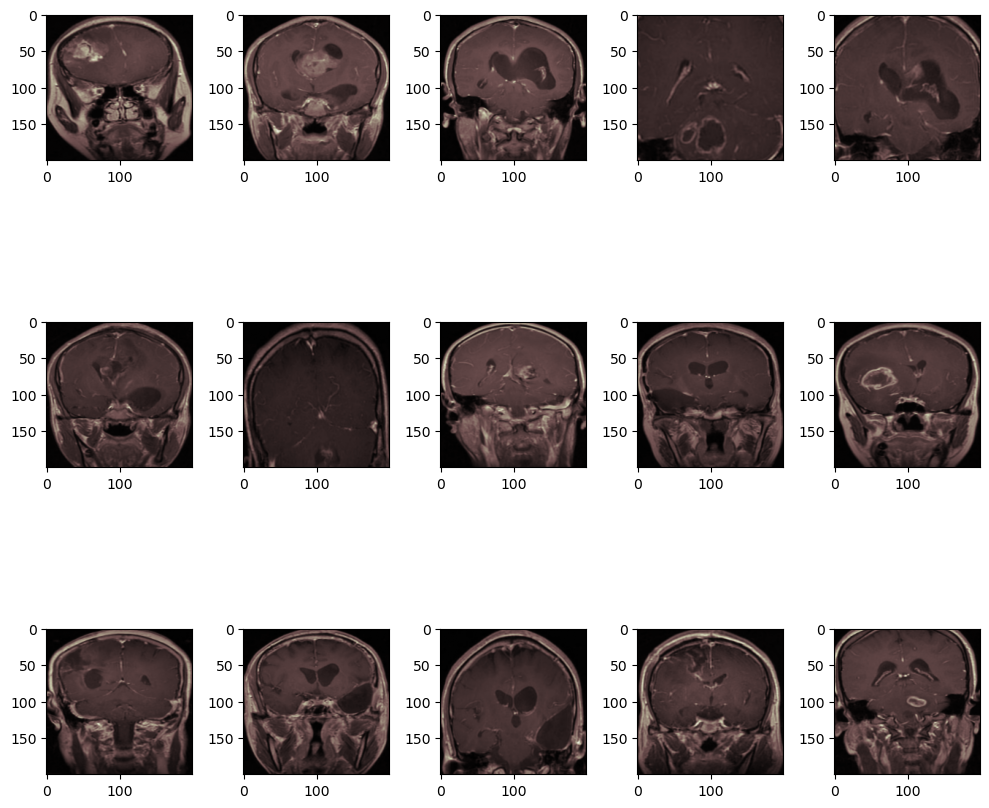

In [3]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [4]:
import random
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [5]:
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(image_size,image_size,3)
)

In [7]:

model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dropout(0.4)(model_vgg)
model_vgg = Dense(4, activation="softmax")(model_vgg)
model_vgg = Model(inputs= vgg.input, outputs= model_vgg)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_vgg.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint_vgg  = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES_vgg  = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL_vgg  = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks_vgg  = [ES_vgg ,RL_vgg,Checkpoint_vgg]

history_vgg  = model_vgg.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks_vgg)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6279 
Epoch 1: val_loss improved from inf to 0.48064, saving model to model-01-0.85-0.48.h5
229/229 [==============================] - 2830s 12s/step - loss: 0.8717 - accuracy: 0.6279 - val_loss: 0.4806 - val_accuracy: 0.8478 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.8262 
Epoch 2: val_loss improved from 0.48064 to 0.32164, saving model to model-02-0.89-0.32.h5
229/229 [==============================] - 2538s 11s/step - loss: 0.4701 - accuracy: 0.8262 - val_loss: 0.3216 - val_accuracy: 0.8915 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9063 
Epoch 3: val_loss improved from 0.32164 to 0.23613, saving model to model-03-0.91-0.24.h5
229/229 [==============================] - 2773s 12s/step - loss: 0.2697 - accuracy: 0.9063 - val_loss: 0.2361 - val_accuracy: 0.9081 - lr: 1

In [1]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_vgg.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

NameError: name 'plt' is not defined

41/41 [==============================] - 68s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.95      0.97      0.96       306
           2       0.97      0.99      0.98       405
           3       1.00      0.97      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



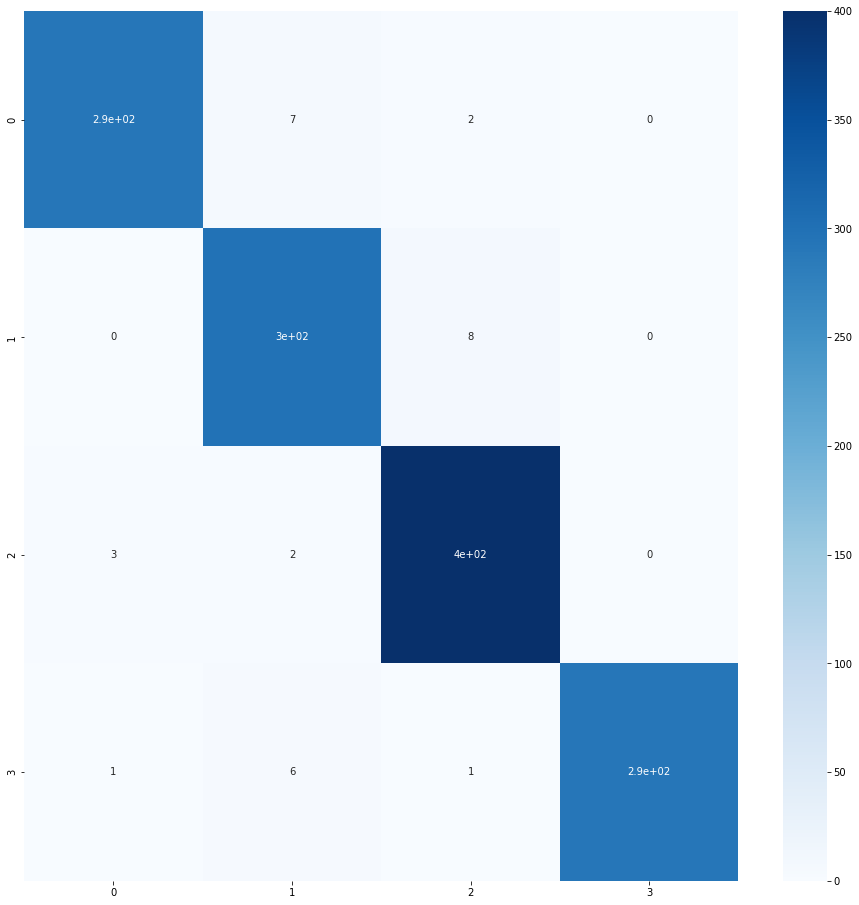

In [14]:
predicted_classes_vgg = np.argmax(model_vgg.predict(x_test), axis = 1)
confusionmatrix_vgg = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes_vgg)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix_vgg, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes_vgg))

In [15]:
loss,acc = model_vgg.evaluate(x_test,y_test)

41/41 [==============================] - 69s 2s/step - loss: 0.1300 - accuracy: 0.9771
